# How to use the dataset: shuffled dataset
In this notebook, we show examples of usage for the dataset
- We use Isolation Forest with a shuffled dataset to perform a classification of normal/attack instances.
- We perform the same classification using XGBoost.

### Import the dataset

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [ ]:
df = pd.read_csv("/data/puccetti/space_data/reduced_final.csv")

## Prepare the data for ML
In this section, we prepare the data to be processed by ML algorithms. In particular, we perform the following steps:
- <strong>Convert mixed dtypes </strong>: we uniform the type of features with mixed type values.
- <strong>Handle NaN values</strong>: we replace NaN and infinite values with -1. 
- <strong>Convert Label to Numeric</strong>: We substitute label values with numeric values. Then, we create two versions of the dataset: with  binary labels (attack, normal), and with multiple labels (one label for each attack).
- <strong>Convert String To Numeric</strong>: we convert the string values to numbers using categorical encoding. This technique assigns a unique number to any unique string values of a feature.
- <strong>Split the dataset in Training and Test sets</strong>: after removing labels and timestamps columns, we split the dataframe in training and test sets with a 60/40 split.

### Convert mixed DTypes

In [ ]:
def convert_dtype(x):
    if not x:
        return ''
    try:
        return str(x)   
    except:        
        return ''
    
def convert_hex(x):
    if not x:
        return 0
    try:
        return literal_eval(x)
    except:        
        return 0

In [ ]:
#Indexes of the columns to be converted
to_convert = [12,15,20,25,29,56,59,60]

In [ ]:
#Convert
for i in to_convert:
    df[df.columns[i]] = df[df.columns[i]].apply(lambda x: convert_dtype(x))

### Handle NaN values

In [ ]:
nanv = []
for col in df.columns:
    nanv.append(df[col].isnull().values.any())

In [ ]:
print(nanv)

In [ ]:
df.replace([np.inf, -np.inf], -1, inplace=True)
df.fillna(-1, inplace=True)
df=df.dropna(thresh=1, axis=1)

In [ ]:
df.replace('nan', -1, inplace=True)

In [ ]:
nanv = []
for col in df.columns:
    nanv.append(df[col].isnull().values.any())
print(nanv)

In [ ]:
#Save the processed dataset
df.to_csv('/data/puccetti/space_data/reduced_final_nan.csv')
#df = pd.read_csv('/data/puccetti/space_data/final_full_dataset_nan.csv')

### Convert Label columns to Numeric values
We substitute label values with numeric values. We create two version of the dataset:
- binary classification
- multiple label classification

In [ ]:
print(df['attack'].value_counts())

In [ ]:
print(df.columns)

In [ ]:
df['attack'] = df['attack'].replace('metasploit SYN flood', 1) 
df['attack'] = df['attack'].replace('nmap discovery', 2)
df['attack'] = df['attack'].replace('nmap SYN flood', 3) 
df['attack'] = df['attack'].replace('ros2 node crashing', 4)
df['attack'] = df['attack'].replace('ros2 reconnaissance', 5)
df['attack'] = df['attack'].replace('ros2 reflection', 6)
df['attack'] = df['attack'].replace('observe', 0)

df['attack'] = pd.to_numeric(df['attack'])

df['attack'].unique(), df['attack'].nunique()

In [ ]:
print(df['attack'].value_counts())

### Convert String to Numeric

In [ ]:
list_column_string=df.select_dtypes(exclude=[np.number])

for i in list_column_string:
    if i != 'timestamp':
        df[i] = pd.Categorical(df[i])

In [ ]:
for i in list_column_string:
    if i != 'timestamp':
        df[i] = df[i].cat.codes

#### Create binary label and multiple labels dataset

In [ ]:
df.to_csv('/data/puccetti/space_data/usable_temp_multi.csv')

In [ ]:
df['attack'] = df['attack'].replace(2, 1)
df['attack'] = df['attack'].replace(3, 1) 
df['attack'] = df['attack'].replace(4, 1)
df['attack'] = df['attack'].replace(5, 1)
df['attack'] = df['attack'].replace(6, 1)

In [ ]:
print(df['attack'].value_counts())

In [ ]:
df.to_csv('/data/puccetti/space_data/usable_temp_bin.csv')

In [30]:
df = pd.read_csv('/data/puccetti/space_data/usable_temp_bin.csv')

## Train / Test Split

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
subs = "Unnamed"
res = [i for i in df.columns if subs in i]
print(len(res))
print(res)
df=df.drop(res, axis=1)

2
['Unnamed: 0.1', 'Unnamed: 0']


In [33]:
label = df['attack']
df = df.drop(['attack'], axis=1)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.4, random_state=42)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [35]:
print("Train Set Shape: " + str(x_train.shape))
print("Train Set Label Shape: " + str(y_train.shape))
print("Test Set Shape: " + str(x_test.shape))
print("Test Set Label Shape: " + str(y_test.shape))

Train Set Shape: (18148230, 60)
Train Set Label Shape: (18148230,)
Test Set Shape: (12098820, 60)
Test Set Label Shape: (12098820,)


## Binary classification with Isolation Forest 

In [36]:
from sklearn.ensemble import IsolationForest as isol
import sklearn
import matplotlib.pyplot as plt

In [37]:
contamination=1-(np.sum(y_train)/np.shape(y_train))
is_forsest = isol(n_estimators=300, contamination='auto')
# fit model
is_forsest.fit(x_train)

IsolationForest(n_estimators=300)

In [38]:
# make predictions
iso_preds = is_forsest.predict(x_test)

In [39]:
iso_preds[iso_preds==1]=0
iso_preds[iso_preds==-1]=1
contamination

array([0.21971008])

In [40]:
len(iso_preds)

12098820

### Compute Accuracy and ROC Curve

In [41]:
iso_preds=1-iso_preds
acc=sklearn.metrics.accuracy_score(y_test, iso_preds)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, iso_preds).ravel()

In [14]:
np.save('./iso_predictions_shuffled.npy', iso_preds)
np.save('./y_test_iso.npy', y_test)


In [ ]:
iso_preds = np.load('./iso_predictions_shuffled.npy')
y_test = np.load('./y_test_iso.npy')

In [42]:
print("accuracy "+str(acc))
print("TN {}, FP {}, FN {}, TP {} ".format(tn, fp, fn, tp))

accuracy 0.8763911687255451
TN 2113026, FP 544949, FN 950572, TP 8490273 


In [43]:
rec=sklearn.metrics.recall_score(y_test, iso_preds)
print(rec)

0.8993128263412862


In [44]:
prec = sklearn.metrics.precision_score(y_test, iso_preds)
print(prec)

0.9396861527032762


In [45]:
preds = is_forsest.decision_function(x_test)

In [19]:
def percent(num_a, num_b):
    return int((num_a / 100) * num_b)

In [50]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test,  preds)
fpr = np.asarray(fpr)
tpr = np.asarray(tpr)
print(fpr, tpr)

[0.         0.         0.         ... 0.99999887 0.99999887 1.        ] [0.00000000e+00 1.05922722e-07 2.11845444e-07 ... 9.99999894e-01
 1.00000000e+00 1.00000000e+00]


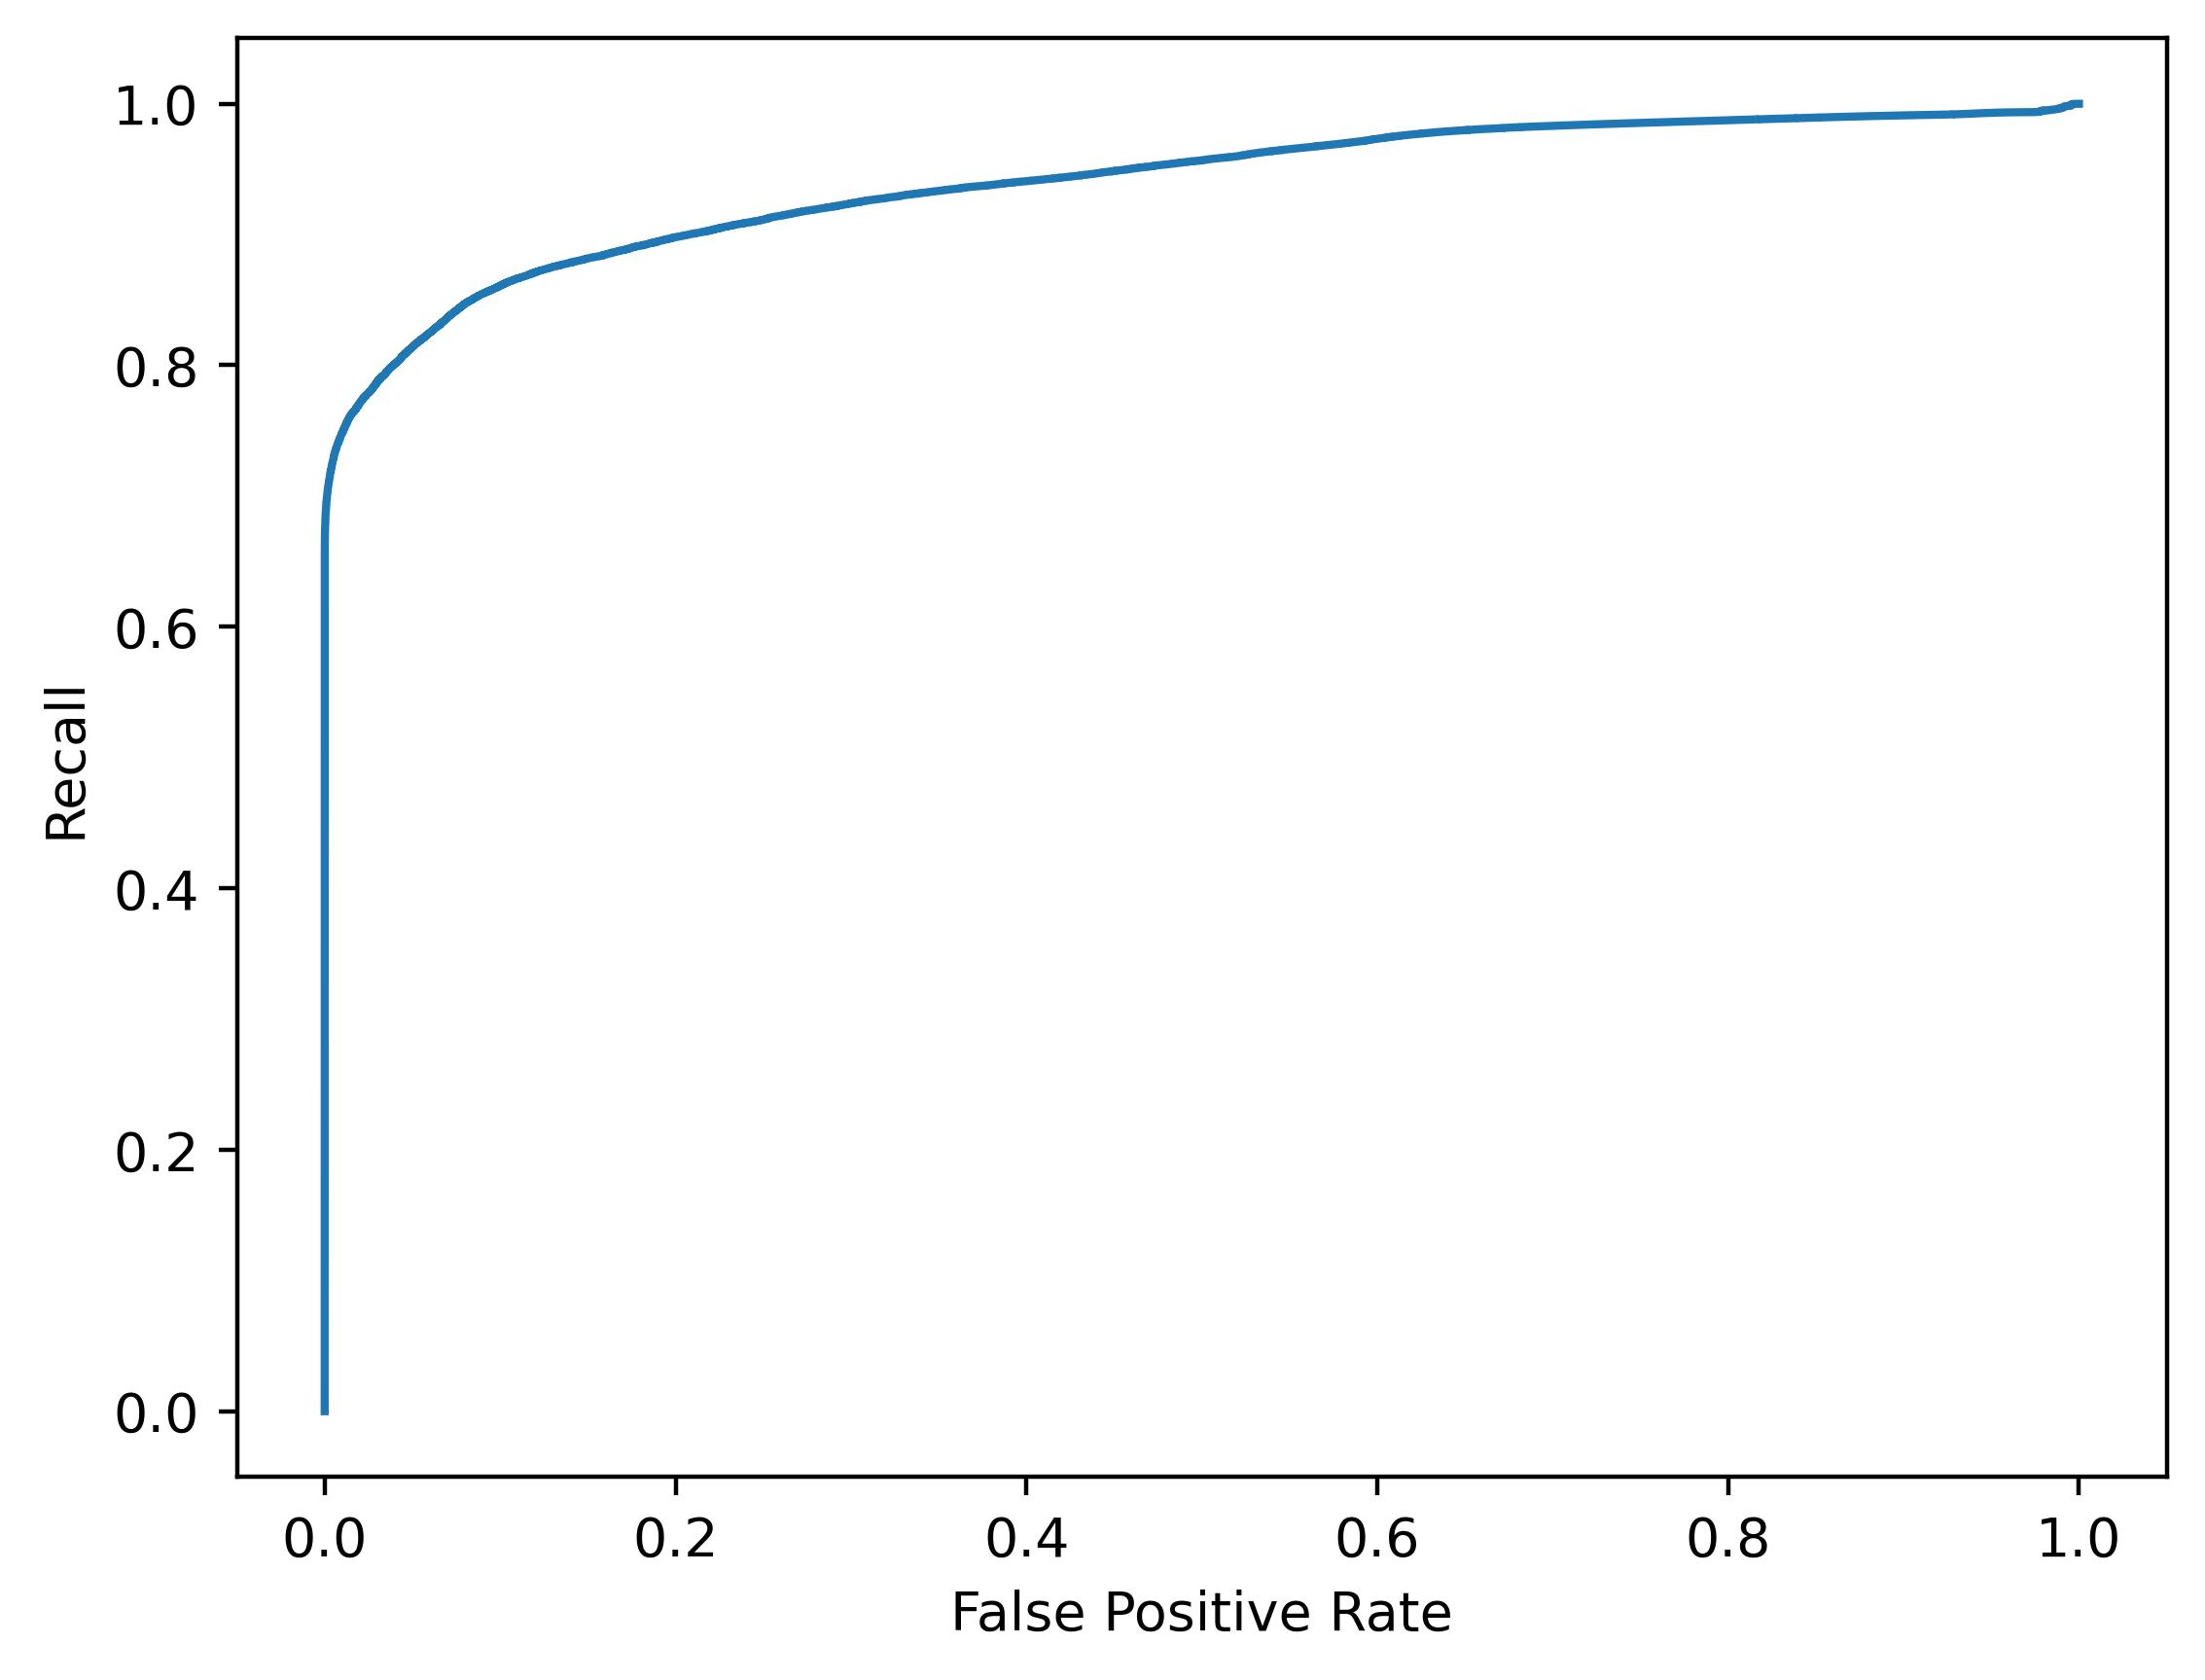

In [51]:
plt.figure(dpi=400)
plt.plot(fpr, tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
np.save('./fpr_iso.npy', fpr)
np.save('./tpr_iso.npy', tpr)

### Compute Precision-Recall Curve

In [53]:
precision, recall, thr = sklearn.metrics.precision_recall_curve(y_test,  preds)

In [24]:
TARGET_TPR=0.005
tpr_index=np.min(np.where(recall >= TARGET_TPR))
tpr_value=tpr[tpr_index]
fpr_index=np.min(np.where(recall >= TARGET_TPR))
fpr_value=fpr[tpr_index]
#p_value=p[tpr_index]
print("TPR {} , FPR {}".format(tpr_value, fpr_value))

TPR 0.0 , FPR 0.0


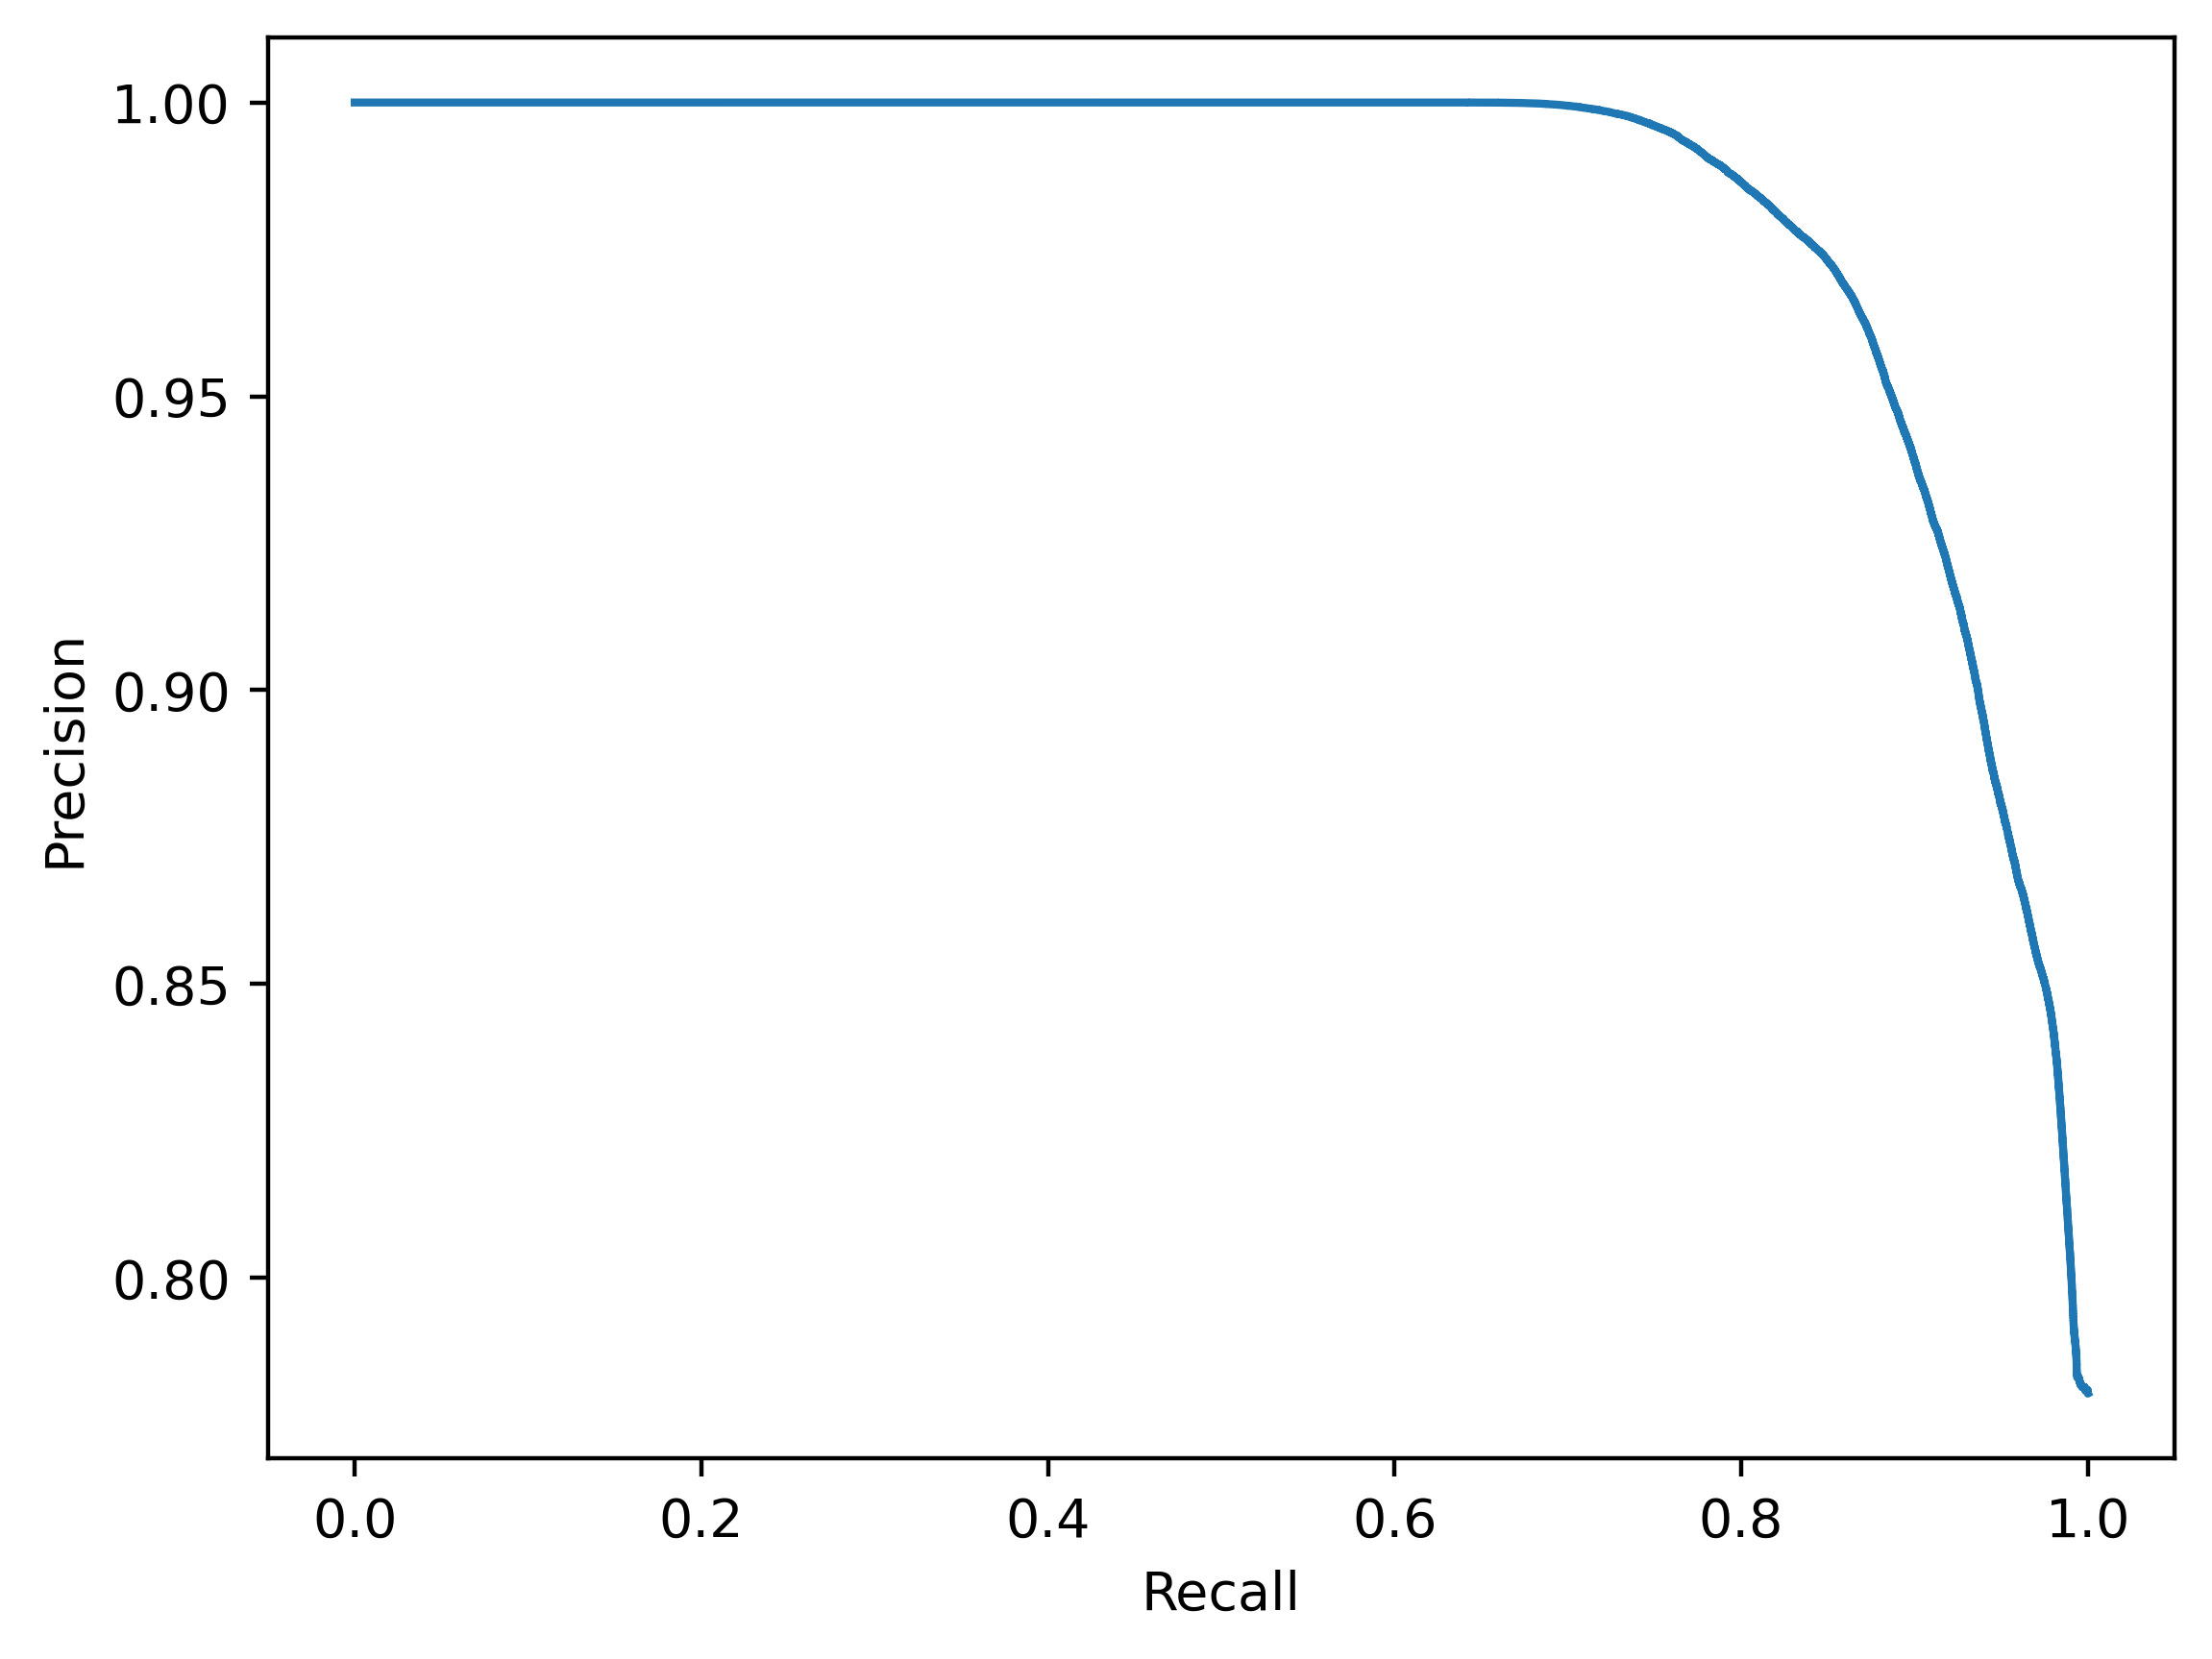

In [54]:
plt.figure(dpi=400)
plt.plot(recall, precision)
#plt.plot(recall[0:percent(len(recall), 100)], precision[0:percent(len(precision), 100)])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [55]:
np.save('./recall_iso.npy', recall)
np.save('./precision_iso.npy', precision)

## Binary classification with XGBoost 

In [ ]:
from xgboost import XGBClassifier

In [ ]:
bst = XGBClassifier(n_estimators=10, max_depth=20, learning_rate=1.0, objective='binary:logistic')
# fit model
bst.fit(x_train, y_train)
# make predictions
xgb_preds = bst.predict(x_test)

In [ ]:
np.save('./xgb_predictions_shuffled.npy', xgb_preds)

First, we compute the Confusion Matrix and the Accuracy

In [ ]:
acc=sklearn.metrics.accuracy_score(y_test, xgb_preds)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, xgb_preds).ravel()

In [ ]:
print("Accuracy "+str(acc))
print("TN {}, FP {}, FN {}, TP {} ".format(tn, fp, fn, tp))

In [ ]:
rec=sklearn.metrics.recall_score(y_test, xgb_preds)
print(rec)

In [ ]:
prec=sklearn.metrics.precision_score(y_test, xgb_preds)
print(prec)

We calculate the ROC curve

In [ ]:
preds_proba = bst.predict_proba(x_test)

In [ ]:
np.save('./xgb_predictions_proba_shuffled.npy', xgb_preds)
np.save('./y_test_xgb.npy', y_test)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  preds_proba[:,1])

In [ ]:
fpr = np.asarray(fpr)
tpr = np.asarray(tpr)

In [ ]:
len(tpr)

In [ ]:
plt.figure(dpi=400)
plt.plot(fpr[percent(len(fpr), 0.02): len(fpr)], tpr[percent(len(tpr), 0.02):len(tpr)])
#plt.plot(fpr, tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

The ROC Curve shows the ratio between the Precision, or True Positive Rate (TPR), and the False Positive Rate (FPR) and has the random guessing on the bisector. This result validate our dataset to be used for Intrusion Detection. 

In [ ]:
np.save('./fpr_xgb.npy', fpr)
np.save('./tpr_xgb.npy', tpr)

We investigate the performance of the XGBoost with a fix FPR of 0.05 

In [ ]:
TARGET_FPR=0.05
fpr_index=np.min(np.where(fpr >= TARGET_FPR))
fpr_value=fpr[fpr_index]
tpr_value=tpr[fpr_index]
print("TPR {} , FPR {}".format(tpr_value, fpr_value))

### Compute the Precision-Recall Curve 

In [ ]:
precision, recall, thr = metrics.precision_recall_curve(y_test,  preds_proba[:,1])

In [ ]:
print(recall)
count = 0
for r in recall:
    if r <= 0.2:
        print(count)
        break
    count = count + 1

In [ ]:
plt.figure(dpi=400)
plt.plot(recall[0:512400], precision[0:512400])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
np.save('./recall_xgb.npy', recall)
np.save('./precision_xgb.npy', precision)